# GLM: Negative Binomial Regression

**[Original tutorial](https://docs.pymc.io/notebooks/GLM-negative-binomial-regression.html)**

Negative binomial (NB) regression is used to model count data where the variance is higher than the mean.
It is a Poisson distribution where the rate parameter is gamma-distributed

In [1]:
import re

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
from scipy import stats

RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

%config InlineBackend.figure_format = "retina"
gg.theme_set(gg.theme_minimal)

## Data generation

Mock data where number of sneezes is affected by consumption of alcohol and/or medications.

### Poisson data

In [2]:
# Real parameters
theta_noalcohol_meds = 1
theta_alcohol_meds = 3
theta_noalcohol_nomeds = 6
theta_alcohol_nomeds = 36

all_thetas = [
    theta_noalcohol_meds,
    theta_alcohol_meds,
    theta_noalcohol_nomeds,
    theta_alcohol_nomeds,
]

q = 1000
df_pois = pd.DataFrame(
    {
        "nsneeze": np.concatenate(
            [np.random.poisson(theta, q) for theta in all_thetas]
        ),
        "alcohol": np.concatenate(
            [np.repeat(b, q) for b in [False, True, False, True]]
        ),
        "nomeds": np.concatenate([np.repeat(b, q) for b in [False, False, True, True]]),
    }
)

The mean and varaince for each group should be very close.

In [3]:
df_pois.groupby(["nomeds", "alcohol"])["nsneeze"].agg(["mean", "var"])

mean        var
nomeds alcohol                   
False  False     1.047   1.047839
       True      3.089   3.066145
True   False     6.002   6.156152
       True     36.004  35.781766

### NB data

Suppose every subject in the dataset had the flu, increasing the varaince of their sneezing.

In [4]:
# Gamma shape parameter.
alpha = 10


def get_nb_vals(mu: float, alpha: float, size: int) -> np.ndarray:
    g = stats.gamma.rvs(alpha, scale=mu / alpha, size=size)
    return stats.poisson.rvs(g)


n = 1000
df_nb = pd.DataFrame(
    {
        "nsneeze": np.concatenate(
            [get_nb_vals(theta, alpha, n) for theta in all_thetas]
        ),
        "alcohol": np.concatenate(
            [np.repeat(b, n) for b in [False, True, False, True]]
        ),
        "nomeds": np.concatenate([np.repeat(b, n) for b in [False, False, True, True]]),
    }
)

In [5]:
df_nb.groupby(["nomeds", "alcohol"])["nsneeze"].agg(["mean", "var"])

mean         var
nomeds alcohol                    
False  False     1.005    1.134109
       True      3.099    4.255454
True   False     5.996    9.557542
       True     36.006  158.450414

## Data visualization

/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/usr/local/Caskroom/miniconda/base/envs/pymc3-tutorials/lib/python3.9/site-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead


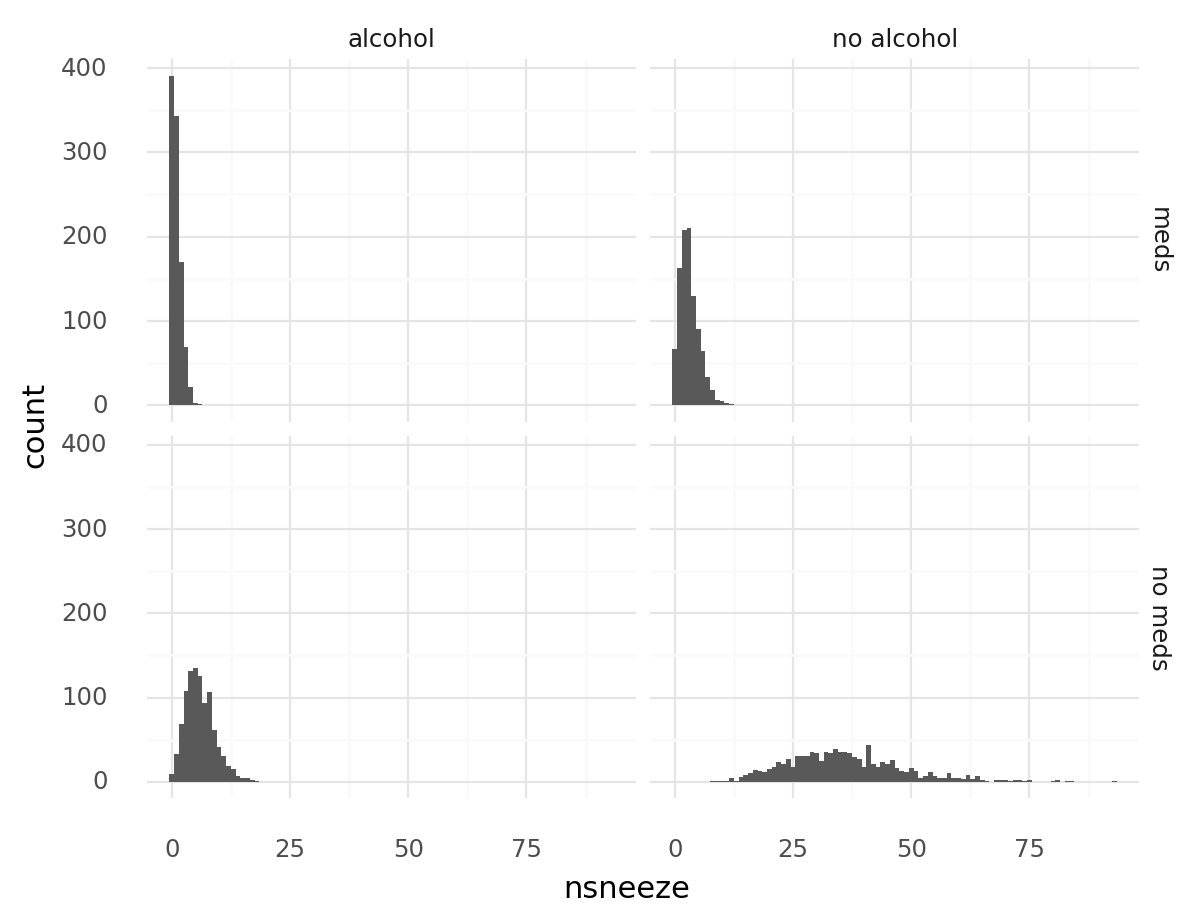

<ggplot: (351093739)>

In [6]:
plot_data = df_nb.copy()
plot_data["meds"] = ["no meds" if b else "meds" for b in plot_data.nomeds]
plot_data["alcohol"] = ["no alcohol" if b else "alcohol" for b in plot_data.alcohol]

(
    gg.ggplot(plot_data, gg.aes(x="nsneeze"))
    + gg.facet_grid("meds ~ alcohol")
    + gg.geom_histogram(binwidth=1)
)

## Model

In [7]:
with pm.Model() as model:
    pm.glm.GLM.from_formula(
        formula="nsneeze ~ alcohol + nomeds + alcohol:nomeds",
        data=df_nb,
        family=pm.glm.families.NegativeBinomial(),
    )
    trace = pm.sample(1000, init="advi", n_init=15000, tune=1000, cores=2, chains=2)

model_az = az.from_pymc3(trace=trace, model=model)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 13700
Interrupted at 13,699 [91%]: Average Loss = 14,125
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, mu, alcohol[T.True]:nomeds[T.True], nomeds[T.True], alcohol[T.True], Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 224 seconds.
The number of effective samples is smaller than 25% for some parameters.


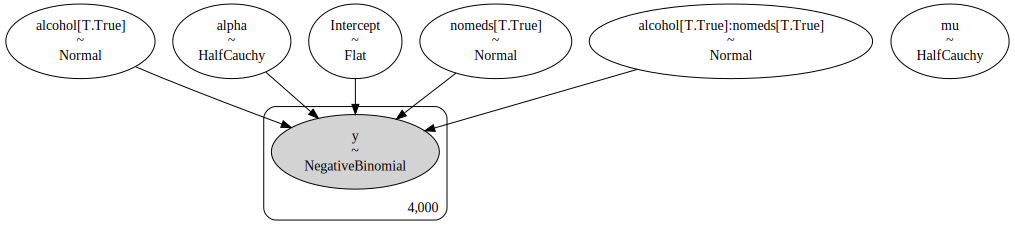

In [8]:
pm.model_to_graphviz(model)

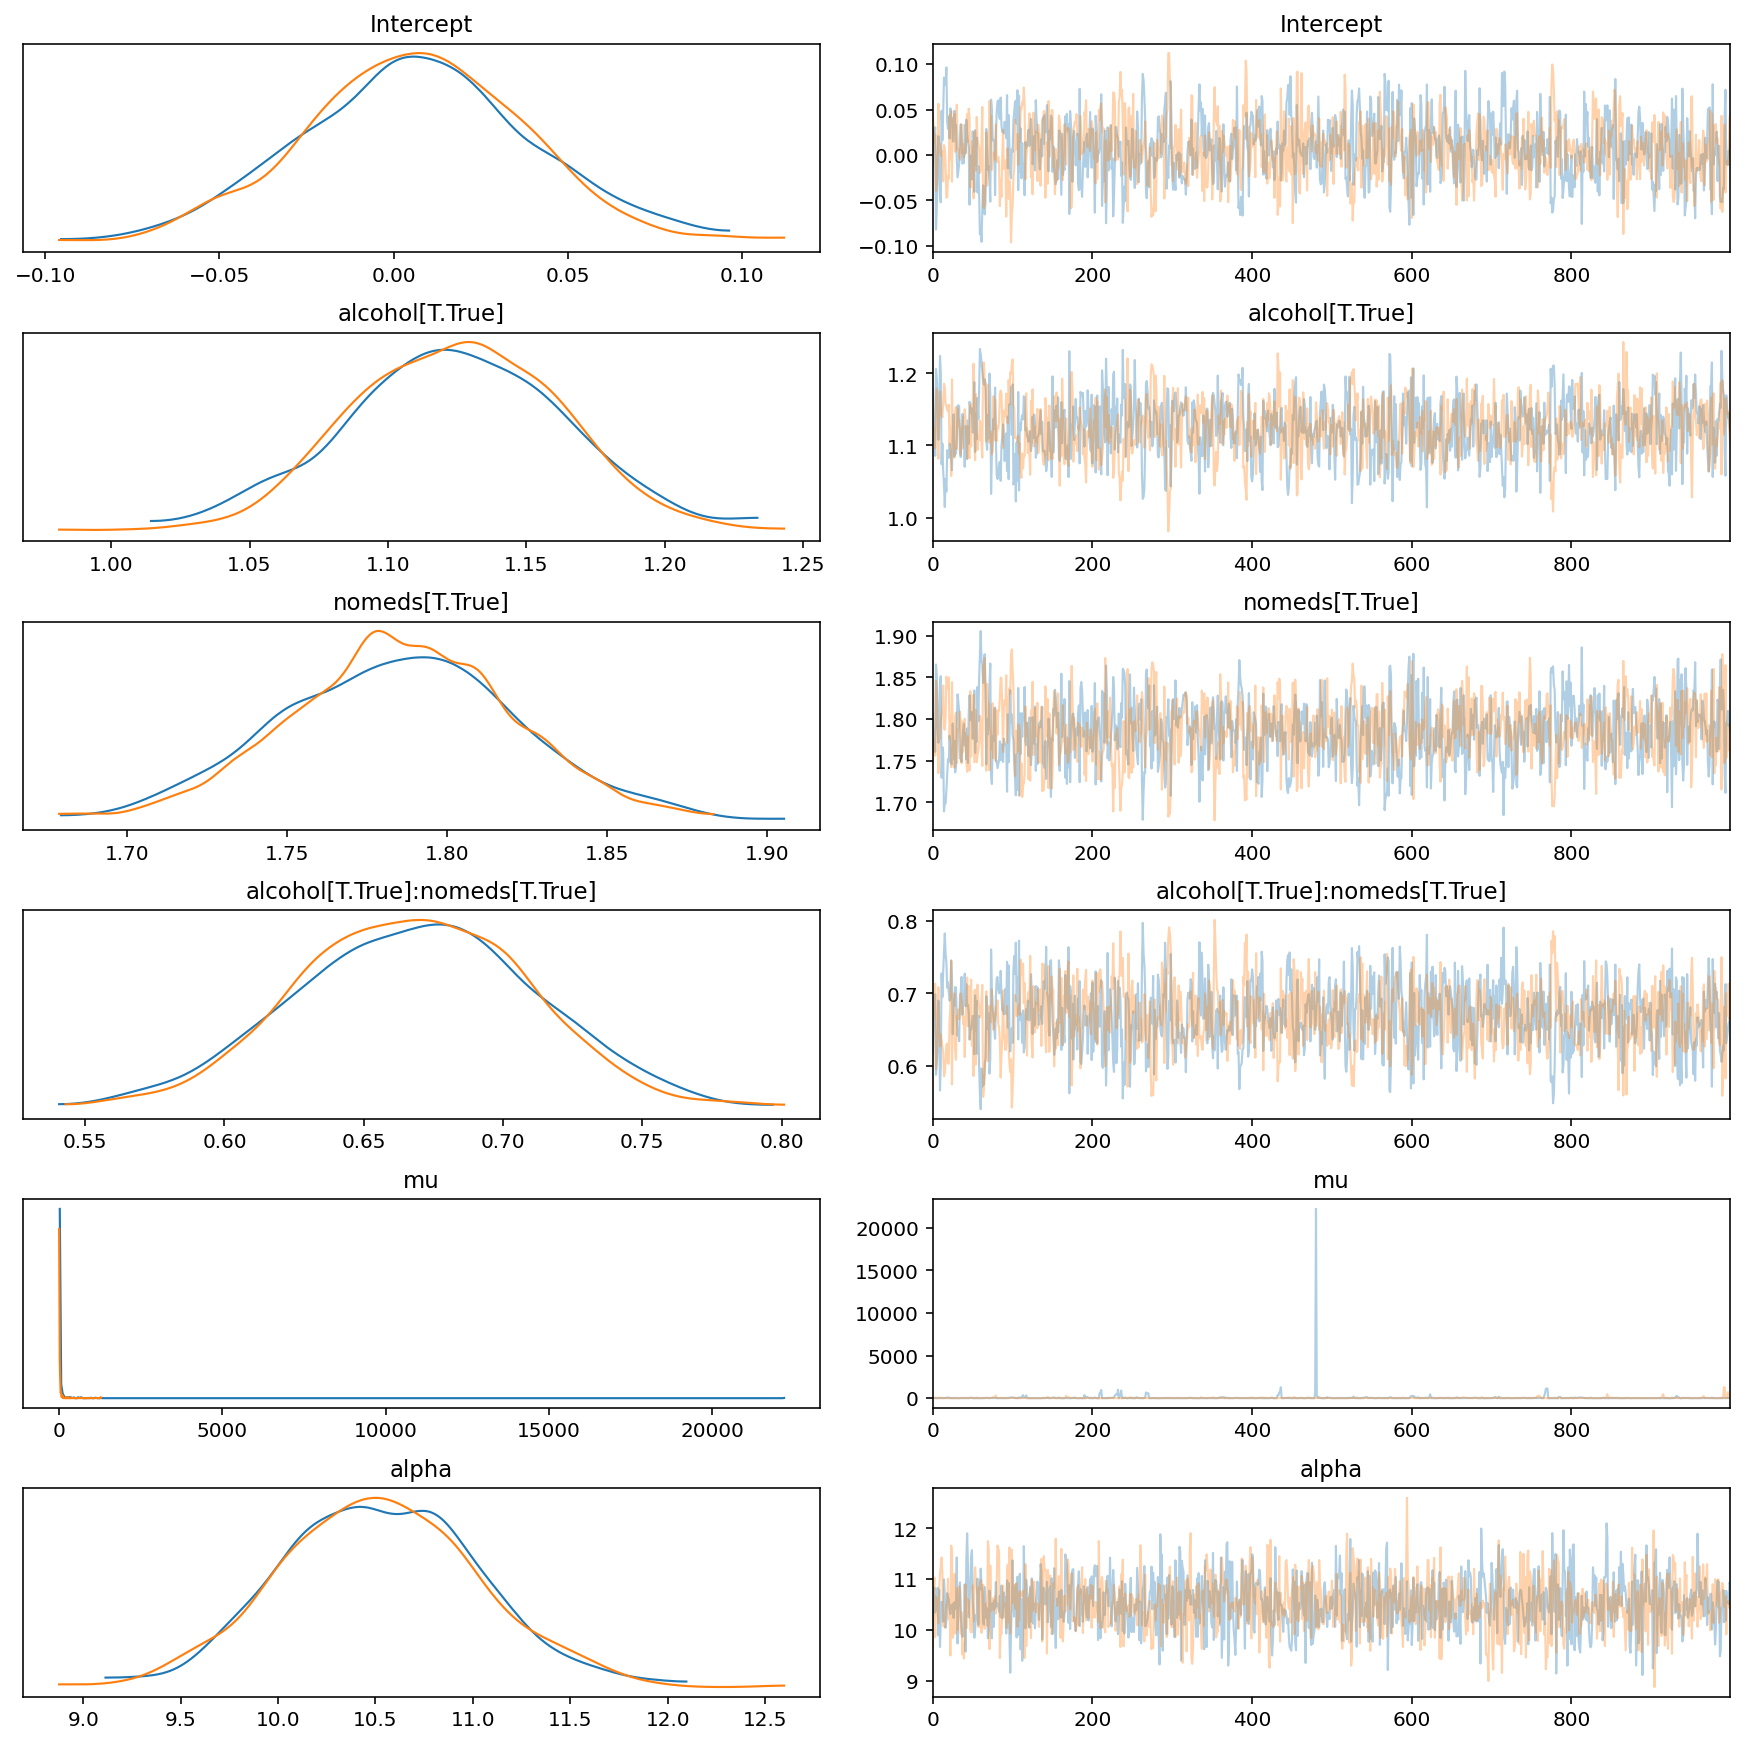

In [9]:
az.plot_trace(model_az, compact=False)
plt.show()

In [10]:
np.exp(az.summary(model_az, hdi_prob=0.89)[["mean", "hdi_5.5%", "hdi_94.5%"]])

,mean,hdi_5.5%,hdi_94.5%
Intercept,1.006018e+00,0.948380,1.053376e+00
alcohol[T.True],3.077138e+00,2.897940,3.270687e+00
nomeds[T.True],5.959580e+00,5.612521,6.296538e+00
alcohol[T.True]:nomeds[T.True],1.950333e+00,1.820298,2.079235e+00
mu,1.090317e+18,1.066092,5.290344e+19
alpha,3.704912e+04,15677.784668,7.811989e+04


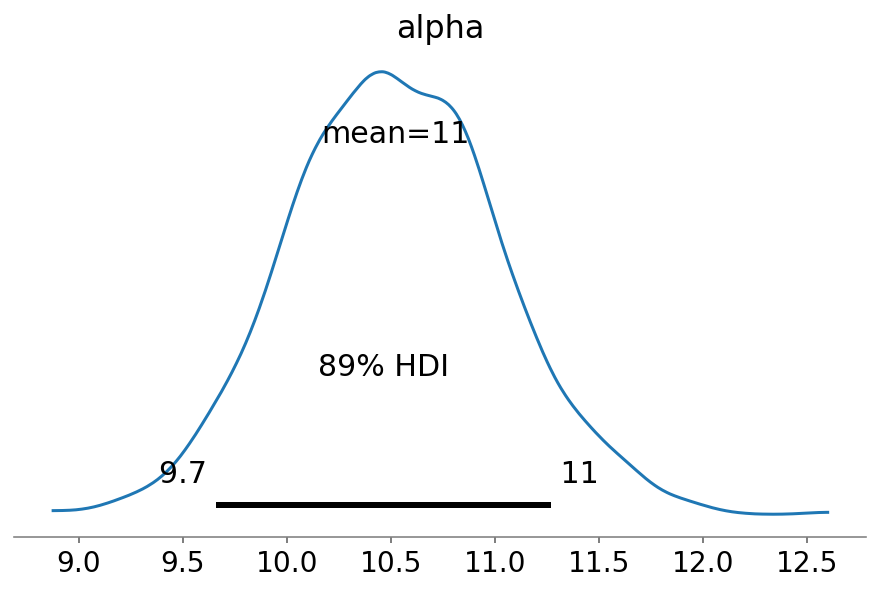

In [11]:
az.plot_posterior(model_az, var_names=["alpha"], hdi_prob=0.89)
plt.show()

---

In [12]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Feb 08 2021

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.20.0

scipy     : 1.6.0
plotnine  : 0.7.1
seaborn   : 0.11.1
re        : 2.2.1
numpy     : 1.20.0
pymc3     : 3.9.3
arviz     : 0.11.0
matplotlib: 3.3.4
pandas    : 1.2.1

Watermark: 2.1.0

